In [15]:
#use bagpy to load bag file
import bagpy

#load the bag file
b = bagpy.bagreader('./high_freq_grub_vibration-5-24.bag')


[INFO]  Data folder ./high_freq_grub_vibration-5-24 already exists. Not creating.


In [16]:
#read the topics and plot the angle_state.position[:2] data
data = b.message_by_topic('/robo_0/joint_0/angle_state')

#load data into a pandas dataframe
import pandas as pd
df = pd.read_csv(data)
df.head()

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,name,position_0,position_1,velocity_0,velocity_1
0,1.714757e+09,129091,1714757011,872703075,joint0,[],0.287375,0.092307,0.005031,-0.002265
1,1.714757e+09,129093,1714757011,875052213,joint0,[],0.287378,0.092282,0.003963,-0.003560
2,1.714757e+09,129094,1714757011,876044511,joint0,[],0.287225,0.092435,0.003472,-0.004204
3,1.714757e+09,129095,1714757011,876405715,joint0,[],0.287225,0.092435,0.002939,-0.004719
4,1.714757e+09,129096,1714757011,877164363,joint0,[],0.287231,0.092475,0.002344,-0.005055


In [17]:
#change Time column to start at 0
df['Time'] = df['Time'] - df['Time'][0]
df.head()

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,name,position_0,position_1,velocity_0,velocity_1
0,0.000000,129091,1714757011,872703075,joint0,[],0.287375,0.092307,0.005031,-0.002265
1,0.002071,129093,1714757011,875052213,joint0,[],0.287378,0.092282,0.003963,-0.003560
2,0.003085,129094,1714757011,876044511,joint0,[],0.287225,0.092435,0.003472,-0.004204
3,0.003626,129095,1714757011,876405715,joint0,[],0.287225,0.092435,0.002939,-0.004719
4,0.004294,129096,1714757011,877164363,joint0,[],0.287231,0.092475,0.002344,-0.005055


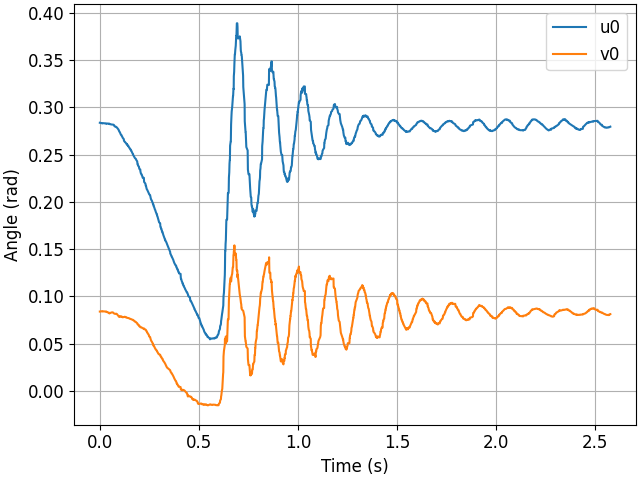

In [19]:
%matplotlib widget
#plot position_0 and position_1 over time
import matplotlib.pyplot as plt

plt.figure()
#make text font bigger
plt.rcParams.update({'font.size': 12})
#constrained layout
plt.rcParams.update({'figure.constrained_layout.use': True})
plt.plot(df['Time'].iloc[14500:16500] - df['Time'].iloc[14499], df['position_0'].iloc[14500:16500], label='u0')
plt.plot(df['Time'].iloc[14500:16500] - df['Time'].iloc[14499], df['position_1'].iloc[14500:16500], label='v0')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid()

plt.savefig('impulse_response.png', dpi=300)
plt.show()



Looks like the unwanted vibrations are somewhere between 5-10 hertz, at approximately 6-7 hz. 

Could try a different foam, like a soft silicone foam https://www.mcmaster.com/products/silicone-foam/cell-type~closed/pressure-to-compress-25~less-than~5~psi/?s=silicone-foam. 

Or just not worry about it and fix it with a software filter.



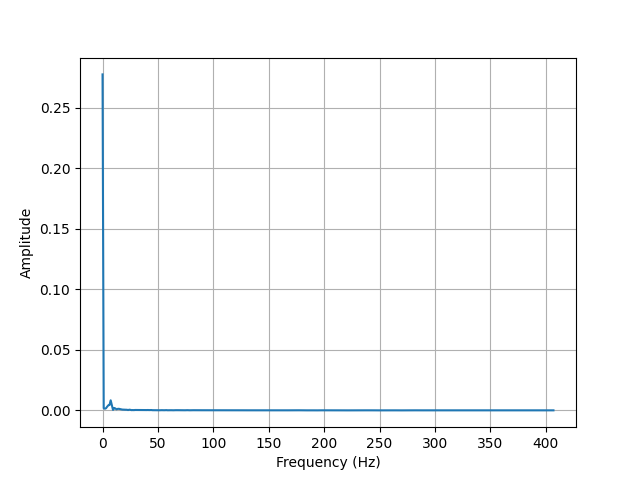

In [5]:
#do fft analysis on the data to see what frequncy it is vibrating at
import numpy as np
from scipy.fft import fft

#compute the fft of the data
def compute_fft(time_series, sampling_rate):
    n = len(time_series)
    fft_values = np.fft.rfft(time_series)
    frequencies = np.fft.rfftfreq(n, d=1/sampling_rate)
    amplitude_spectrum = np.abs(fft_values) / n
    return frequencies, amplitude_spectrum


#compute the fft of the position_0 data from Time = 19 to 20 seconds
start_time = 19
end_time = 20
start_index = np.where(df['Time'] > start_time)[0][0]
end_index = np.where(df['Time'] > end_time)[0][0]

sampling_rate = 1/np.mean(np.diff(df['Time']))
frequencies, amplitude_spectrum = compute_fft(df['position_0'][start_index:end_index], sampling_rate)

#plot the fft
plt.figure()
plt.plot(frequencies, amplitude_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()



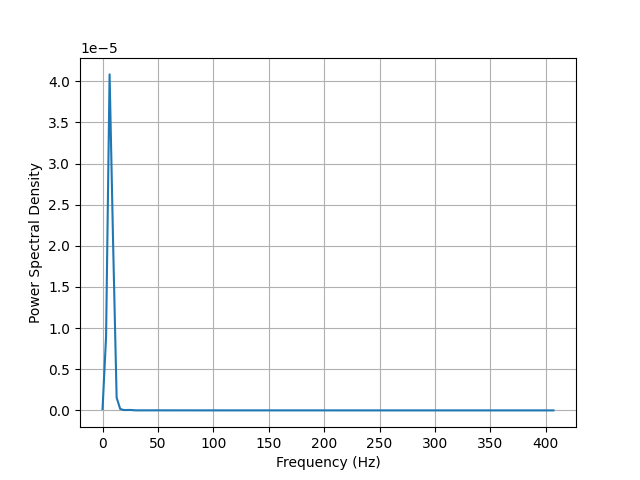

In [6]:
#compute PSD of the data
from scipy.signal import welch

#compute the PSD of the position_0 data from Time = 15.5 to 17 seconds
frequencies, psd = welch(df['position_0'][start_index:end_index], fs=sampling_rate)

#plot the PSD
plt.figure()
plt.plot(frequencies, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.grid()
plt.show()

[8.09825979e-13 6.47860783e-12 2.26751274e-11 4.53502548e-11
 5.66878185e-11 4.53502548e-11 2.26751274e-11 6.47860783e-12
 8.09825979e-13] [  1.          -7.67794021  25.79721953 -49.54122564  59.47613197
 -45.70873448  21.96012013  -6.03017224   0.72460093]


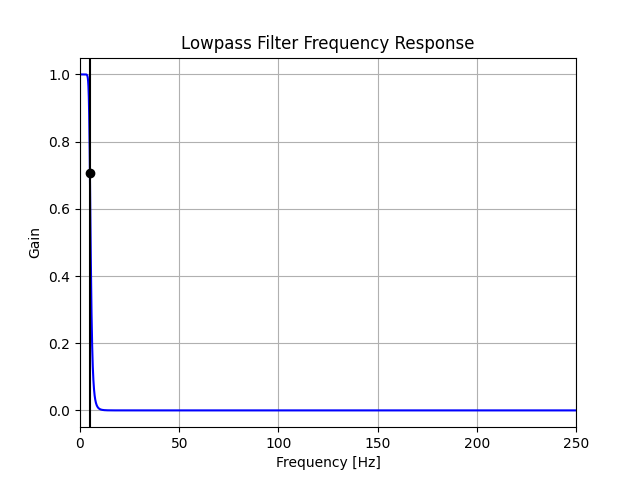

In [7]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Sensor frequency
fs = 500  # Hz

# Cutoff frequency of the filter
fc = 5  # Hz

# Normalized cutoff frequency
fc_norm = fc / (fs / 2)

# Filter order
order = 8

# Design the Butterworth filter
b, a = signal.butter(order, fc_norm, btype='low')
print(b,a)

# Frequency response of the filter
w, h = signal.freqz(b, a, worN=8000)

# Plot the frequency response
plt.figure()
plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
plt.plot(fc, 0.5 * np.sqrt(2), 'ko')
plt.axvline(fc, color='k')
plt.xlim(0, 0.5 * fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()
plt.show()


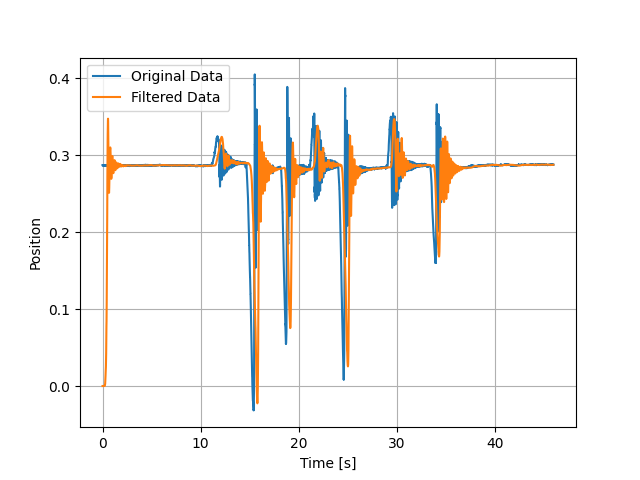

In [8]:
from scipy.signal import butter, sosfilt

# Filter order
N = 20

# Cutoff frequency of the filter
fc = 3  # Hz

# Sample rate
fs = 500  # Hz

# Design the Butterworth filter
sos = butter(N, fc, btype='low', fs=fs, output='sos')

# Apply the filter to your data
filtered_data = sosfilt(sos, df['position_0'])

# Plot the filtered data
plt.figure()
plt.plot(df['Time'], df['position_0'], label='Original Data')
plt.plot(df['Time'], filtered_data, label='Filtered Data')
plt.xlabel('Time [s]')
plt.ylabel('Position')
plt.legend()
plt.grid()
plt.show()


# Now look at hysteresis loop

[INFO]  Data folder ./hysteresis_pressure_ramp_5-24 already exists. Not creating.


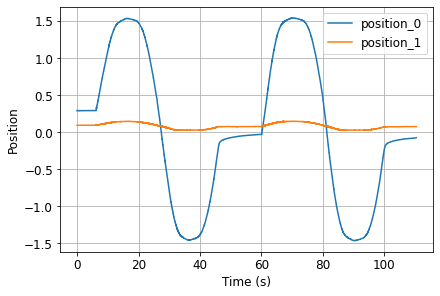

In [6]:
import bagpy
import pandas as pd
import matplotlib.pyplot as plt
#load new bag file
b = bagpy.bagreader('./hysteresis_pressure_ramp_5-24.bag')

#read the topics and plot the angle_state.position[:2] data
data = b.message_by_topic('/robo_0/joint_0/angle_state')

#load data into a pandas dataframe
df_angles = pd.read_csv(data)

#change Time column to start at 0
df_angles['Time'] = df_angles['Time'] - df_angles['Time'][0]

#plot position_0 and position_1 over time
plt.figure()
plt.plot(df_angles['Time'], df_angles['position_0'], label='position_0')
plt.plot(df_angles['Time'], df_angles['position_1'], label='position_1')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.legend()
plt.grid()
plt.show()



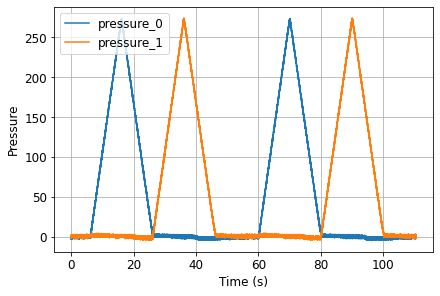

In [7]:
#extract pressure0 and pressure1 data
data = b.message_by_topic('/robo_0/joint_0/pressure_state')
df_pressures = pd.read_csv(data)
df_pressures['Time'] = df_pressures['Time'] - df_pressures['Time'][0]

#plot pressure_0 and pressure_1 over time
plt.figure()
plt.plot(df_pressures['Time'], df_pressures['pressure_0'], label='pressure_0')
plt.plot(df_pressures['Time'], df_pressures['pressure_1'], label='pressure_1')
plt.xlabel('Time (s)')
plt.ylabel('Pressure')
plt.legend()
plt.grid()
plt.show()


In [8]:
#interpolate the pressure data dn angle data to be at the same time points
from scipy.interpolate import interp1d
import numpy as np

#unifrorm time points
# time = np.arange(0, 60, 0.001)
time = np.arange(df_angles['Time'].iloc[0], df_angles['Time'].iloc[-1], 0.001)

#interpolate the pressure data
pressure_0_interp = interp1d(df_pressures['Time'], df_pressures['pressure_0'], kind='linear')(time)
pressure_1_interp = interp1d(df_pressures['Time'], df_pressures['pressure_1'], kind='linear')(time)
diff_pressure_interp = pressure_0_interp - pressure_1_interp

#interpolate the angle data
angle_0_interp = interp1d(df_angles['Time'], df_angles['position_0'], kind='linear')(time)
angle_1_interp = interp1d(df_angles['Time'], df_angles['position_1'], kind='linear')(time)


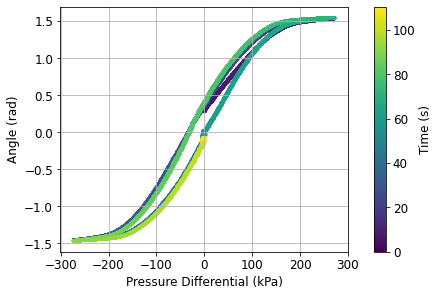

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Create a colormap
cmap = matplotlib.colormaps['viridis']

# Normalize the time values to the range [0, 1] for the colormap
norm = plt.Normalize(min(time), max(time))

#make text font bigger
plt.rcParams.update({'font.size': 12})
#constrained layout
plt.rcParams.update({'figure.constrained_layout.use': True})

plt.figure()
plt.scatter(diff_pressure_interp, angle_0_interp, c=time, cmap=cmap, norm=norm, label='angle_0',s=5 )

plt.xlabel('Pressure Differential (kPa)')
plt.ylabel('Angle (rad)')
# plt.legend()
plt.grid()

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Time (s)')

plt.savefig('hysteresis_loop_grub.png', dpi=300)
plt.show()




In [ ]:
#possible model: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10081230
#or adaptive control to deal with this. 



# Looking into limit cycle behavior with PID controller.